In [ ]:
import utils
import os, pickle

config = utils.create_config(features = ['distance.origin-prob','distance.head-prob', 'pose.prob_x','pose.prob_y'],
                            contamination = 0.04,
                            grouped_range = 60,
                            add_golay = False,
                            add_mv_stats = False,
                            show_true_annotations = False)

In [ ]:
bouts_dict = utils.read_pickle('bouts_dict.pkl')
true_peak_annotations_df = utils.read_pickle('true_annotations.pkl')
fly_db = utils.create_fly_database(bouts_dict, true_peak_annotations_df=true_peak_annotations_df)


In [ ]:
bouts_dict = utils.read_pickle('bouts_dict.pkl')

In [ ]:
import matplotlib.pyplot as plt
trace = bouts_dict['Fly08022022_6d_SD_B']['pose.thor_post_x'][0]
plt.plot(bouts_dict['Fly08022022_6d_SD_B']['pose.thor_post_x'][0])
plt.show()

In [ ]:
trace.std()

In [ ]:
trace = bouts_dict['Fly08022022_6d_SD_B']['distance.origin-thor_post'][0]

In [ ]:
plt.plot(trace)
plt.show()

In [ ]:
trace.std()

In [ ]:
bouts_dict['Fly08022022_6d_SD_B'].columns

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# List of columns of interest
columns_of_interest = ['distance.origin-thor_post','distance.origin-halt','distance.head-prob','distance.avg(origin-joint1,origin-joint2,origin-joint3)']

# Dictionary to store standard deviations, organized by column
std_dict = {col: [] for col in columns_of_interest}

# Your existing dictionary of DataFrames
dict_of_dfs = bouts_dict

# Iterate over experiments (keys)
for exp_key, df in dict_of_dfs.items():
    
    # Iterate only over specified columns
    for col in columns_of_interest:
        
        # Skip if the column is not in the DataFrame
        if col not in df.columns:
            continue
        
        # Iterate over rows in the specific column
        for idx, cell_data in enumerate(df[col]):
            
            # Convert cell_data to a NumPy array for easier calculations
            time_series = np.array(cell_data)
            
            # Compute standard deviation
            std_dev = np.std(time_series)
            
            # Store this standard deviation in the dictionary under the appropriate column
            std_dict[col].append(std_dev)

# Create histograms for each column
for col, std_list in std_dict.items():
    
    # Convert std_list to a NumPy array for easier manipulation
    std_array = np.array(std_list)
    
    plt.figure()  # Create a new figure for each column
    plt.hist(std_array, bins=50)  # You can change the number of bins as needed
    plt.xlabel('Standard Deviation')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Standard Deviations for Column {col}')
    plt.show()

with open('bouts_std.pkl', 'wb') as f:
    pickle.dump(std_dict, f)

In [ ]:
normalized_std_array

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

# List of columns of interest
columns_of_interest = ['distance.origin-thor_post', 'distance.origin-halt', 'distance.head-prob', 'distance.avg(origin-joint1,origin-joint2,origin-joint3)']

# Dictionary to store standard deviations, organized by column
std_dict = {col: [] for col in columns_of_interest}

# Additional dictionaries to store experiment keys and indices corresponding to each standard deviation
exp_keys_dict = {col: [] for col in columns_of_interest}
idxs_dict = {col: [] for col in columns_of_interest}

# Dictionaries to store filtered and removed standard deviations
filtered_bouts_dict = {col: [] for col in columns_of_interest}
removed_bouts_dict = {col: [] for col in columns_of_interest}

# Your existing dictionary of DataFrames (for demonstration, replace with your actual dictionary)
dict_of_dfs = bouts_dict  # Replace this with your bouts_dict

# Iterate over experiments (keys)
for exp_key, df in dict_of_dfs.items():
    
    # Iterate only over specified columns
    for col in columns_of_interest:
        
        # Skip if the column is not in the DataFrame
        if col not in df.columns:
            continue
        
        # Iterate over rows in the specific column
        for idx, cell_data in enumerate(df[col]):
            
            # Convert cell_data to a NumPy array for easier calculations
            time_series = np.array(cell_data)
            
            # Compute standard deviation
            std_dev = np.std(time_series)
            
            # Store this standard deviation in the dictionary under the appropriate column
            std_dict[col].append(std_dev)
            exp_keys_dict[col].append(exp_key)
            idxs_dict[col].append(idx)

# Calculate the 95th percentile for the 'distance.origin-thor_post' column
percentile_95 = np.percentile(std_dict['distance.origin-thor_post'], 95)

# Separate data based on the 95th percentile
for col in columns_of_interest:
    for exp_key, idx, std_dev in zip(exp_keys_dict[col], idxs_dict[col], std_dict[col]):
        if col == 'distance.origin-thor_post' and std_dev > percentile_95:
            removed_bouts_dict[col].append((exp_key, idx, std_dev))
        else:
            filtered_bouts_dict[col].append((exp_key, idx, std_dev))

# Create histograms for each column in filtered_bouts_dict
for col, std_list in filtered_bouts_dict.items():
    
    # Extract the standard deviation values from the tuples
    std_array = np.array([t[2] for t in std_list])
    
    plt.figure()  # Create a new figure for each column
    plt.hist(std_array, bins=50)  # You can change the number of bins as needed
    plt.xlabel('Standard Deviation')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Standard Deviations for Column {col} (Filtered)')
    plt.show()

# Save the filtered and removed dictionaries
with open('filtered_bouts_std.pkl', 'wb') as f:
    pickle.dump(filtered_bouts_dict, f)

with open('removed_bouts_std.pkl', 'wb') as f:
    pickle.dump(removed_bouts_dict, f)


In [ ]:
import pandas as pd
# Step 1: Calculate the 95th percentile based on the standard deviations of "distance.origin-thor_post"
all_std_values = []
for exp_key, df in bouts_dict.items():
    if "distance.origin-thor_post" in df.columns:
        for time_series in df["distance.origin-thor_post"]:
            all_std_values.append(np.std(time_series) / np.sqrt(len(time_series)))

# Calculate the 95th percentile
percentile_95 = np.percentile(all_std_values, 95)

# Step 2: Create two new dictionaries of DataFrames
filtered_bouts_dict = {}
removed_bouts_dict = {}

for exp_key, df in bouts_dict.items():
    if "distance.origin-thor_post" not in df.columns:
        continue
    
    # Initialize empty DataFrames with the same columns for each experiment
    filtered_df = pd.DataFrame(columns=df.columns)
    removed_df = pd.DataFrame(columns=df.columns)
    
    for idx, row in df.iterrows():
        time_series = row["distance.origin-thor_post"]
        std_dev = np.std(time_series) / np.sqrt(len(time_series))
        
        if std_dev > percentile_95:
            removed_df = removed_df.append(row)
        else:
            filtered_df = filtered_df.append(row)
    
    # Store the filtered and removed DataFrames in their respective dictionaries
    filtered_bouts_dict[exp_key] = filtered_df.reset_index(drop=True)
    removed_bouts_dict[exp_key] = removed_df.reset_index(drop=True)

filtered_bouts_dict, removed_bouts_dict

In [ ]:
import pywt
import numpy as np
from scipy import signal
def create_wavelet_filter_bank(signal_length, sampling_frequency, freq_limits, wavelet_name):
    # Create wavelet
    wavelet = pywt.ContinuousWavelet(wavelet_name)
    
    # Create scales
    scales = np.arange(1, signal_length, 1)
    
    # Create frequencies
    frequencies = pywt.scale2frequency(wavelet, scales) * sampling_frequency
    
    # Filter frequencies within the limits
    valid_indices = np.where((frequencies >= freq_limits[0]) & (frequencies <= freq_limits[1]))
    valid_frequencies = frequencies[valid_indices]
    valid_scales = scales[valid_indices]
    
    return valid_scales, valid_frequencies

def get_scale_spectrum(filter_bank, signal):
    valid_scales, _ = filter_bank
    coeffs, _ = pywt.cwt(signal, valid_scales, 'cmor')
    return coeffs


In [ ]:
signal_length = 1000  # Replace with size(tsSnap{i}, 1)
sampling_frequency = 30
freq_limits = [0.25, 1]
wavelet_name = 'cmor'  # or any other wavelet type you want to use

# Create the filter bank
filter_bank = create_wavelet_filter_bank(signal_length, sampling_frequency, freq_limits, wavelet_name)


# Get the scale spectrum
coeffs = get_scale_spectrum(filter_bank, trace)

In [ ]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(15, 6))
plt.imshow(coeffs, aspect='auto', cmap='jet', interpolation='nearest')
plt.colorbar(label='Coefficient Value')
plt.xlabel('Time')
plt.ylabel('Scale')
plt.title('Wavelet Transform Coefficients')
plt.show()

In [ ]:
#save some portion of it:

In [ ]:
import pandas as pd
import pickle

dict_of_dfs = bouts_dict



# Slice the first 5 key-value pairs from the dictionary
sliced_dict_of_dfs = {k: dict_of_dfs[k] for k in list(dict_of_dfs.keys())[:5]}

# Save the sliced dictionary in .pkl format
with open('sliced_dict_of_dfs.pkl', 'wb') as f:
    pickle.dump(sliced_dict_of_dfs, f)


In [ ]:
#one approach to achieve this, requires further tuning though

# Importing necessary libraries and modules
from scipy.signal import savgol_filter
import numpy as np
import matplotlib.pyplot as plt

# Function for smoothing the time series using Savitzky-Golay filter
def smooth_time_series(time_series, window_length=11, polyorder=3):
    return savgol_filter(time_series, window_length, polyorder)

# Function to check if the time series is stationary
def is_stationary(time_series, threshold=5):
    return np.max(time_series) - np.min(time_series) <= threshold

# Function to segment the time series
def segment_time_series(time_series, window_size=75):
    segments = []
    start = 0
    while start + window_size <= len(time_series):
        segments.append(time_series[start:start + window_size])
        start += window_size // 2  # 50% overlap
    return segments

# Function to calculate correlation between two segments
def calculate_correlation(segment1, segment2):
    return np.corrcoef(segment1, segment2)[0, 1]

# Function to check for significant change in the segment
def significant_change(segment, rate_threshold=15, points_threshold=30):
    return np.max(segment) - np.min(segment) >= rate_threshold and len(segment) >= points_threshold

# Initialize the annotation dictionary
annotations = {}

# Iterate through each experiment and DataFrame
for exp_key, df in bouts_dict.items():
    annotation = []
    
    # If "distance.origin-thor_post" not in columns, continue to next iteration
    if "distance.origin-thor_post" not in df.columns:
        continue
    
    # Apply Savitzky-Golay smoothing to the time series data
    df_smooth = df.apply(lambda x: smooth_time_series(x) if isinstance(x, np.ndarray) else x)
    
    # Check if the "distance.origin-thor_post" column is stationary
    if is_stationary(df_smooth['distance.origin-thor_post'].iloc[0]):
        annotation.append(True)
        continue
    
    # Segment the time series
    thor_segments = segment_time_series(df_smooth['distance.origin-thor_post'].iloc[0])
    prob_segments = segment_time_series(df_smooth['distance.origin-prob'].iloc[0])
    
    # Check each segment for correlation and significant change
    for thor_seg, prob_seg in zip(thor_segments, prob_segments):
        corr = calculate_correlation(thor_seg, prob_seg)
        if corr < 0.8:
            if significant_change(thor_seg) or significant_change(prob_seg):
                annotation.append(True)
            else:
                annotation.append(False)
        else:
            annotation.append(False)
            
    annotations[exp_key] = annotation

# Check first few annotations to see if the code works as expected
first_few_annotations = {key: annotations[key] for key in list(annotations.keys())[:5]}
first_few_annotations


In [ ]:
trace = df['distance.origin-thor_post'][76]
ts_thor_data_smooth = smooth_time_series(trace)
plt.plot(trace)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df is your DataFrame and annotation is your boolean list
df['Annotation'] = annotation

# Filter the DataFrame based on the Annotation column
true_df = df[df['Annotation'] == True]
false_df = df[df['Annotation'] == False]

# Plot 'distance.origin-thor_post' for rows where Annotation is True
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for index, row in true_df.iterrows():
    plt.plot(row['distance.origin-thor_post'])
plt.title("Rows where Annotation is True")

# Plot 'distance.origin-thor_post' for rows where Annotation is False
plt.subplot(1, 2, 2)
for index, row in false_df.iterrows():
    plt.plot(row['distance.origin-thor_post'])
plt.title("Rows where Annotation is False")

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df is your DataFrame and annotation is your boolean list
df['Annotation'] = annotation

# Filter the DataFrame based on the Annotation column
false_df = df[df['Annotation'] == False]

# Create a figure for each row where Annotation is False
for index, row in false_df.iterrows():
    plt.figure(figsize=(10, 6))

    # Plot 'distance.origin-prob' and 'distance.origin-thor_post' in the same subplot
    plt.plot(row['distance.origin-prob'], label='distance.origin-prob')
    plt.plot(row['distance.origin-thor_post'], label='distance.origin-thor_post')

    plt.title(f"Row {index}")
    plt.xlabel("Time")
    plt.ylabel("Distance")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
#one approach to achieve this to filter in a stepwise fashion. If there is very little movement in the entire thorax trace then it is kept. Below code, then tries to identify the largest possible window where standard deviation remains below a threshold. If it does not find, then the trace is labeled as False. True labeled traces have Start and End indices that correspond to sections
# Importing necessary libraries and modules
from scipy.signal import savgol_filter
import numpy as np
import matplotlib.pyplot as plt

# Function for smoothing the time series using Savitzky-Golay filter
def smooth_time_series(time_series, window_length=61, polyorder=3):
    return savgol_filter(time_series, window_length, polyorder)

# Function to check if the time series is stationary
def is_stationary(time_series, threshold=10):
    return np.max(time_series) - np.min(time_series) <= threshold

# Function to segment the time series
def segment_time_series(time_series, window_size=75):
    segments = []
    start = 0
    while start + window_size <= len(time_series):
        segments.append(time_series[start:start + window_size])
        start += window_size // 2  # 50% overlap
    return segments

# Function to calculate correlation between two segments
def calculate_correlation(segment1, segment2):
    return np.corrcoef(segment1, segment2)[0, 1]

# Function to check for significant change in the segment
def significant_change(segment, rate_threshold=15, points_threshold=30):
    return np.max(segment) - np.min(segment) >= rate_threshold and len(segment) >= points_threshold

def find_stable_window(time_series, window_size=60, threshold=2):
    """
    Find the stable window in a time series according to specified conditions.

    Parameters:
        time_series (array-like): The time series data.
        window_size (int): The size of the rolling window for calculating standard deviation.
        threshold (float): The threshold for standard deviation to identify change.

    Returns:
        tuple: The indices (start, end) of the stable window.
    """
    # Calculate the midpoint of the time series
    midpoint = len(time_series) // 2

    # Calculate the rolling standard deviation
    rolling_std = pd.Series(time_series).rolling(window=window_size, center=True).std()

    # Step 2: From beginning to midpoint, find the last index where rolling_std exceeds the threshold
    last_exceed_before_mid = rolling_std[:midpoint][rolling_std[:midpoint] > threshold].last_valid_index()
    start = 0 if last_exceed_before_mid is None else last_exceed_before_mid + 1

    # Step 3: From midpoint to end, find the first index where rolling_std exceeds the threshold
    first_exceed_after_mid = rolling_std[midpoint:][rolling_std[midpoint:] > threshold].first_valid_index()
    end = len(time_series) if first_exceed_after_mid is None else first_exceed_after_mid - 1

    start = start + window_size

    return start, end


In [ ]:
bouts_dict_filt = {}  # Initialize new dictionary to hold filtered bouts

# Main loop iterating through bouts_dict
for exp_key, df in bouts_dict.items():
    if "distance.origin-thor_post" not in df.columns:
        continue

    modified_data_list = []  # Initialize a list to hold modified data
    start_indices = []  # Initialize a list to hold start indices
    end_indices = []  # Initialize a list to hold end indices
    annotation = []  # Initialize a list to hold annotations

    for index, row in df.iterrows():
        ts_thor_data = row['distance.origin-thor_post']
        ts_thor_data_smooth = smooth_time_series(ts_thor_data)

        if is_stationary(ts_thor_data_smooth):
            annotation.append(True)
            modified_data_list.append(ts_thor_data)  # Save the entire ts_thor_data
            start_indices.append(0)  # Start index is 0 for the entire series
            end_indices.append(len(ts_thor_data) - 1)  # End index for the entire series
            continue

        start, end = find_stable_window(ts_thor_data_smooth)

        if end - start <= 0 or len(ts_thor_data_smooth[start:end]) < 150:
            annotation.append(False)
            modified_data_list.append(None)  # Save None if conditions are not met
            start_indices.append(None)  # No start index
            end_indices.append(None)  # No end index
            continue

        annotation.append(True)
        modified_data_list.append(ts_thor_data[start:end])  # Save the modified ts_thor_data
        start_indices.append(start)  # Save the start index
        end_indices.append(end)  # Save the end index

    df['Annotation'] = annotation
    df['ModifiedData'] = modified_data_list  # Add the modified data to the DataFrame
    df['StartIndex'] = start_indices  # Add the start indices to the DataFrame
    df['EndIndex'] = end_indices  # Add the end indices to the DataFrame
    bouts_dict_filt[exp_key] = df  # Save the modified DataFrame into bouts_dict_filt


In [ ]:
# Predict the peaks in these

config = utils.create_config()


true_peak_annotations_df = utils.read_pickle('true_annotations.pkl')
fly_db = utils.create_fly_database(bouts_dict_filt, true_peak_annotations_df=true_peak_annotations_df)

for fly in fly_db.fly_data:
    info_df = utils.get_model_prediction


In [ ]:
import pandas as pd
expt_info_df_path = r'Z:\mfk\basty-projects\expt_info_df.pkl'
expt_info_df = pd.read_pickle(expt_info_df_path)

In [506]:
import os
import glob
import pandas as pd


import numpy as np
import pandas as pd

def slice_correct_annotation(bouts_dict_filt):
    bouts_edited_dict = {}

    for key, df in bouts_dict_filt.items():
        modified_rows = []

        # Iterate through rows
        for index, row in df.iterrows():
            modified_row = row.copy()
            if row['Annotation']:  # Assuming Annotation is a boolean flag
                start = int(row['start_index'])
                new_start = start + int(row['StartIndex'])
                new_stop = start + int(row['EndIndex'])

                # Update start and stop index
                modified_row['start_index'] = new_start
                modified_row['stop_index'] = new_stop

                # Slice numpy arrays in the relevant columns
                for col in df.columns:
                    if isinstance(row[col], np.ndarray):
                        old_list = row[col]
                        modified_row[col] = old_list[int(row['StartIndex']):int(row['EndIndex']) + 1]
            else:
                modified_row = row.copy()

            modified_rows.append(modified_row)

        # Create a new DataFrame with modified rows
        bouts_edited_dict[key] = pd.DataFrame(modified_rows)

    return bouts_edited_dict

def generate_tick_data(FPS=30, sd=False):

    if sd == False:
        xticks = np.arange(
            start=0, stop=FPS * 60 * 60 * 16 + 1, step=FPS * 60 * 60 * 2
        )
        ZT_ticks = xticks
        ZT_ticklabels = [
            "ZT" + str((tick + 10) % 24) for tick in range(0, len(xticks) * 2, 2)
        ]
    else:
        xticks = np.arange(
            start=0, stop=FPS * 60 * 60 * 6 + 1, step=FPS * 60 * 60 * 1
        )
        ZT_ticks = xticks
        ZT_ticklabels = [
            "ZT" + str(tick) for tick in range(0, len(xticks) * 1, 1)
        ]

    return ZT_ticks, ZT_ticklabels

def load_annotated_flies(expt_info_df):
    basty_path = r'Z:\mfk\basty-projects'
    annotated_dict = {}

    for expt in expt_info_df.ExptNames:
        folder_path = os.path.join(basty_path, expt, 'annotations')

        if os.path.exists(folder_path):
            annotation_paths = glob.glob(os.path.join(folder_path, '*Pumping.csv'))
            if annotation_paths:  # Checking if list is not empty
                annotation_path = annotation_paths[0]  # Taking the first match
                annotated_dict[expt] = pd.read_csv(annotation_path)

    return annotated_dict
import matplotlib.pyplot as plt

def prob_pump_ethograms(bouts_dict_filt, annotated_dict, expt_info_df,SD):
    idx_sd = expt_info_df[expt_info_df['SD'] == SD]
    fig, ax = plt.subplots()
    color = '#377eb8'  # The color to use for the bar
    red_color = '#d62728'

    i = 0  # Counter for which horizontal line (y-value) to plot on
    valid_exptNames = []  # List to store valid experiment names

    ZT_ticks, ZT_ticklabels = generate_tick_data(30, sd=SD)

    for expts in idx_sd.ExptNames:
        df = bouts_dict_filt.get(expts, None)

        if df is None:  # Check if the experiment name exists in bouts_dict_filt
            df = annotated_dict.get(expts, None)
            if df is not None:

                for idx, row in df.iterrows():
                    start, stop = row['Start'], row['Finish']
                    if expts in ["Fly11242021_F_B_SD_5D_9am", "Fly11192021_F_A_SD_5D_9am", "Fly11152020_F_SD","Fly11052021_F_A_SD_5D_8am"]:
                        if start < 1512000 or stop < 1512000:
                            continue
                        start, stop = start - 1512000, stop - 1512000
                    ax.barh(i, stop - start, left=start, color=red_color, edgecolor='none', rasterized=True)
                valid_exptNames.append(expts)
                i += 1
            continue

        if not df['Annotation'].any():  # Skip if no True annotations
            continue

        valid_exptNames.append(expts)
        for idx, row in df.iterrows():
            if row['Annotation']:  # Only plot if annotation is True
                start, stop = row['start_index'], row['stop_index']
                stop = start + row['EndIndex']
                start = row['StartIndex'] + start
                ax.barh(i, stop - start, left=start, color=color, edgecolor='none', rasterized=True)

        i += 1  # Move to the next line for the next experiment

    # Customizing the plot (you can add more here)
    ax.set_xlabel('Time')
    ax.set_ylabel('Experiment Name')
    ax.set_yticks(range(len(valid_exptNames)))
    ax.set_xticks(ZT_ticks)
    ax.set_xticklabels(ZT_ticklabels)
    ax.set_yticklabels(valid_exptNames)


    plt.savefig(f'Fig_1 {SD}.pdf')
    plt.show()



In [508]:
bouts_edited_dict = slice_correct_annotation(bouts_dict_filt)

In [509]:
bouts_dict_filt['Fly08022022_6d_SD_B']

,start_index,stop_index,region,pose.prob_x,pose.prob_y,pose.halt_x,pose.halt_y,pose.thor_post_x,pose.thor_post_y,distance.origin-halt,...,distance.origin-thor_post,distance.head-prob,distance.thor_post-halt,"distance.avg(thor_post-joint1,thor_post-joint2,thor_post-joint3)","distance.avg(origin-joint1,origin-joint2,origin-joint3)",distance.origin-prob_segmented,Annotation,ModifiedData,StartIndex,EndIndex
0,26510,28105,Fly08022022_6d_SD_B,"[560.2674867659807, 563.4234387129545, 566.579...","[376.944912130634, 374.4901364892721, 371.6412...","[740.2003645102183, 739.9911094071964, 739.681...","[361.2953839302063, 361.13586648305255, 360.97...","[759.0354959170023, 759.0294677217802, 758.802...","[401.19881904125214, 401.02297647794086, 400.8...","[823.6691897056337, 823.4111707173753, 823.063...",...,"[858.5425886128569, 858.4551010584281, 858.172...","[66.63783410754098, 65.34948492424904, 65.0285...","[44.12534769010063, 44.197744637693894, 44.218...","[181.1475453188581, 180.98023535151233, 180.88...","[748.3288001704823, 748.2642331183318, 748.115...","[[675.2681863587532, 676.5270383501934, 677.59...",True,"[865.07023617753, 864.7159967523028, 864.50039...",104.0,1595.0
1,130126,131384,Fly08022022_6d_SD_B,"[895.3112794607878, 895.1558222522339, 895.000...","[150.66675655047098, 150.65931006272635, 150.6...","[897.2066330115, 897.2326778968176, 897.258722...","[339.5045042037964, 339.46439003944397, 339.42...","[862.1325496435165, 861.999044418335, 861.8655...","[342.9556700189908, 342.9983994960785, 342.945...","[959.2929952285162, 959.3031587515733, 959.313...",...,"[927.8421874182083, 927.7339352610716, 927.590...","[87.89273998615339, 87.80470302158548, 87.5877...","[35.24346562964858, 35.41042432583423, 35.5678...","[160.47512030666215, 160.5446340061484, 160.56...","[1008.4972109530501, 1008.5044679774234, 1008....","[[907.9001920140515, 907.7456548068129, 907.59...",False,None,NaN,NaN
2,164295,165605,Fly08022022_6d_SD_B,"[932.1198892593384, 931.9556339581808, 931.879...","[621.9242204229037, 622.0024285068115, 621.823...","[752.4093451313674, 752.6971930861473, 752.695...","[595.462761554867, 595.9712180693945, 596.3370...","[757.0845412413279, 757.225207666556, 757.2043...","[562.5580627123514, 562.6832326352596, 562.726...","[959.5289068285341, 960.0701835006035, 960.296...",...,"[943.2118407384769, 943.3994039718938, 943.408...","[88.52484354528991, 88.18473874507596, 87.8602...","[33.23517210100221, 33.594536613913384, 33.911...","[172.65856018119766, 172.92136918763921, 173.0...","[1057.1972576159126, 1057.702175561525, 1057.9...","[[1120.5521959736984, 1120.4589794966907, 1120...",True,"[943.2118407384769, 943.3994039718938, 943.408...",0.0,1310.0
3,439906,441017,Fly08022022_6d_SD_B,"[1001.2057900031408, 1001.5866277217865, 1001....","[470.04109370708466, 470.20261603593826, 470.3...","[862.2910725275675, 862.2778785228729, 862.275...","[355.19462289412814, 355.0527958869934, 355.14...","[831.1597726643085, 830.9471826752027, 831.026...","[389.5113400419553, 389.5192061463992, 389.562...","[932.581960952304, 932.5157519619052, 932.5484...",...,"[917.9028552720952, 917.7136984663451, 917.804...","[82.98369185772786, 83.13882496129297, 83.3214...","[46.33351818047191, 46.57838488471763, 46.4889...","[177.97973925502473, 178.258162379317, 178.174...","[1028.804927253763, 1028.8074517790158, 1028.8...","[[1106.0522879634423, 1106.4656673201118, 1106...",True,"[917.9028552720952, 917.7136984663451, 917.804...",0.0,1111.0


,start_index,stop_index,region,pose.prob_x,pose.prob_y,pose.halt_x,pose.halt_y,pose.thor_post_x,pose.thor_post_y,distance.origin-halt,...,distance.origin-thor_post,distance.head-prob,distance.thor_post-halt,"distance.avg(thor_post-joint1,thor_post-joint2,thor_post-joint3)","distance.avg(origin-joint1,origin-joint2,origin-joint3)",distance.origin-prob_segmented,Annotation,ModifiedData,StartIndex,EndIndex
0,26510,28105,Fly08022022_6d_SD_B,"[560.2674867659807, 563.4234387129545, 566.579...","[376.944912130634, 374.4901364892721, 371.6412...","[740.2003645102183, 739.9911094071964, 739.681...","[361.2953839302063, 361.13586648305255, 360.97...","[759.0354959170023, 759.0294677217802, 758.802...","[401.19881904125214, 401.02297647794086, 400.8...","[823.6691897056337, 823.4111707173753, 823.063...",...,"[858.5425886128569, 858.4551010584281, 858.172...","[66.63783410754098, 65.34948492424904, 65.0285...","[44.12534769010063, 44.197744637693894, 44.218...","[181.1475453188581, 180.98023535151233, 180.88...","[748.3288001704823, 748.2642331183318, 748.115...","[[675.2681863587532, 676.5270383501934, 677.59...",True,"[865.07023617753, 864.7159967523028, 864.50039...",104.0,1595.0
1,130126,131384,Fly08022022_6d_SD_B,"[895.3112794607878, 895.1558222522339, 895.000...","[150.66675655047098, 150.65931006272635, 150.6...","[897.2066330115, 897.2326778968176, 897.258722...","[339.5045042037964, 339.46439003944397, 339.42...","[862.1325496435165, 861.999044418335, 861.8655...","[342.9556700189908, 342.9983994960785, 342.945...","[959.2929952285162, 959.3031587515733, 959.313...",...,"[927.8421874182083, 927.7339352610716, 927.590...","[87.89273998615339, 87.80470302158548, 87.5877...","[35.24346562964858, 35.41042432583423, 35.5678...","[160.47512030666215, 160.5446340061484, 160.56...","[1008.4972109530501, 1008.5044679774234, 1008....","[[907.9001920140515, 907.7456548068129, 907.59...",False,None,NaN,NaN
2,164295,165605,Fly08022022_6d_SD_B,"[932.1198892593384, 931.9556339581808, 931.879...","[621.9242204229037, 622.0024285068115, 621.823...","[752.4093451313674, 752.6971930861473, 752.695...","[595.462761554867, 595.9712180693945, 596.3370...","[757.0845412413279, 757.225207666556, 757.2043...","[562.5580627123514, 562.6832326352596, 562.726...","[959.5289068285341, 960.0701835006035, 960.296...",...,"[943.2118407384769, 943.3994039718938, 943.408...","[88.52484354528991, 88.18473874507596, 87.8602...","[33.23517210100221, 33.594536613913384, 33.911...","[172.65856018119766, 172.92136918763921, 173.0...","[1057.1972576159126, 1057.702175561525, 1057.9...","[[1120.5521959736984, 1120.4589794966907, 1120...",True,"[943.2118407384769, 943.3994039718938, 943.408...",0.0,1310.0
3,439906,441017,Fly08022022_6d_SD_B,"[1001.2057900031408, 1001.5866277217865, 1001....","[470.04109370708466, 470.20261603593826, 470.3...","[862.2910725275675, 862.2778785228729, 862.275...","[355.19462289412814, 355.0527958869934, 355.14...","[831.1597726643085, 830.9471826752027, 831.026...","[389.5113400419553, 389.5192061463992, 389.562...","[932.581960952304, 932.5157519619052, 932.5484...",...,"[917.9028552720952, 917.7136984663451, 917.804...","[82.98369185772786, 83.13882496129297, 83.3214...","[46.33351818047191, 46.57838488471763, 46.4889...","[177.97973925502473, 178.258162379317, 178.174...","[1028.804927253763, 1028.8074517790158, 1028.8...","[[1106.0522879634423, 1106.4656673201118, 1106...",True,"[917.9028552720952, 917.7136984663451, 917.804...",0.0,1111.0


In [510]:
bouts_edited_dict['Fly08022022_6d_SD_B']

,start_index,stop_index,region,pose.prob_x,pose.prob_y,pose.halt_x,pose.halt_y,pose.thor_post_x,pose.thor_post_y,distance.origin-halt,...,distance.origin-thor_post,distance.head-prob,distance.thor_post-halt,"distance.avg(thor_post-joint1,thor_post-joint2,thor_post-joint3)","distance.avg(origin-joint1,origin-joint2,origin-joint3)",distance.origin-prob_segmented,Annotation,ModifiedData,StartIndex,EndIndex
0,26614,28209,Fly08022022_6d_SD_B,"[564.2624338699712, 562.7259637282954, 561.797...","[369.9650528828303, 365.2051903804143, 358.590...","[748.1017343799273, 747.6840396399299, 747.266...","[360.618423897773, 360.63676662991446, 360.820...","[766.4197666794062, 765.918998281161, 765.4005...","[401.18232110018533, 401.374940811346, 401.899...","[830.4829032778274, 830.1146309863257, 829.818...",...,"[865.07023617753, 864.7159967523028, 864.50039...","[81.77397035504332, 85.48858798346576, 90.5092...","[44.50820220557807, 44.633088088144454, 44.903...","[191.42525356378314, 192.26312736191403, 193.2...","[743.6268211559485, 742.4760331968831, 741.370...","[[675.2681863587532, 676.5270383501934, 677.59...",True,"[870.4855152602737, 870.4824638033342, 870.492...",104.0,1595.0
1,130126,131384,Fly08022022_6d_SD_B,"[895.3112794607878, 895.1558222522339, 895.000...","[150.66675655047098, 150.65931006272635, 150.6...","[897.2066330115, 897.2326778968176, 897.258722...","[339.5045042037964, 339.46439003944397, 339.42...","[862.1325496435165, 861.999044418335, 861.8655...","[342.9556700189908, 342.9983994960785, 342.945...","[959.2929952285162, 959.3031587515733, 959.313...",...,"[927.8421874182083, 927.7339352610716, 927.590...","[87.89273998615339, 87.80470302158548, 87.5877...","[35.24346562964858, 35.41042432583423, 35.5678...","[160.47512030666215, 160.5446340061484, 160.56...","[1008.4972109530501, 1008.5044679774234, 1008....","[[907.9001920140515, 907.7456548068129, 907.59...",False,None,NaN,NaN
2,164295,165605,Fly08022022_6d_SD_B,"[932.1198892593384, 931.9556339581808, 931.879...","[621.9242204229037, 622.0024285068115, 621.823...","[752.4093451313674, 752.6971930861473, 752.695...","[595.462761554867, 595.9712180693945, 596.3370...","[757.0845412413279, 757.225207666556, 757.2043...","[562.5580627123514, 562.6832326352596, 562.726...","[959.5289068285341, 960.0701835006035, 960.296...",...,"[943.2118407384769, 943.3994039718938, 943.408...","[88.52484354528991, 88.18473874507596, 87.8602...","[33.23517210100221, 33.594536613913384, 33.911...","[172.65856018119766, 172.92136918763921, 173.0...","[1057.1972576159126, 1057.702175561525, 1057.9...","[[1120.5521959736984, 1120.4589794966907, 1120...",True,"[943.2118407384769, 943.3994039718938, 943.408...",0.0,1310.0
3,439906,441017,Fly08022022_6d_SD_B,"[1001.2057900031408, 1001.5866277217865, 1001....","[470.04109370708466, 470.20261603593826, 470.3...","[862.2910725275675, 862.2778785228729, 862.275...","[355.19462289412814, 355.0527958869934, 355.14...","[831.1597726643085, 830.9471826752027, 831.026...","[389.5113400419553, 389.5192061463992, 389.562...","[932.581960952304, 932.5157519619052, 932.5484...",...,"[917.9028552720952, 917.7136984663451, 917.804...","[82.98369185772786, 83.13882496129297, 83.3214...","[46.33351818047191, 46.57838488471763, 46.4889...","[177.97973925502473, 178.258162379317, 178.174...","[1028.804927253763, 1028.8074517790158, 1028.8...","[[1106.0522879634423, 1106.4656673201118, 1106...",True,"[917.9028552720952, 917.7136984663451, 917.804...",0.0,1111.0


In [505]:
annotated_dict = load_annotated_flies(expt_info_df)

In [ ]:
prob_pump_ethograms(bouts_dict_filt,annotated_dict,expt_info_df,SD=True)

In [ ]:
prob_pump_ethograms(bouts_dict_filt,annotated_dict,expt_info_df,SD=False)

In [511]:
true_peak_annotations_df = utils.read_pickle('true_annotations.pkl')
fly_db = utils.create_fly_database(bouts_edited_dict, true_peak_annotations_df=true_peak_annotations_df)

for fly in fly_db.fly_data:
    info_df = utils.get_model_prediction(fly, config, bouts_edited_dict)

    anomalies = info_df.loc[info_df['predictions'] == -1, ['distance.origin-prob']]
    group_pred_idx, group_pred_val = utils.filter_prediction(anomalies, grouped_range=config['grouped_range'])

    fly.peak_index = group_pred_idx
    fly.peak_values = group_pred_val


In [523]:
fly_db.fly_data[3].peak_index

[54, 325, 539, 740, 1053]

In [522]:
fly_db.fly_data[3].name

'Fly08022022_6d_SD_B'

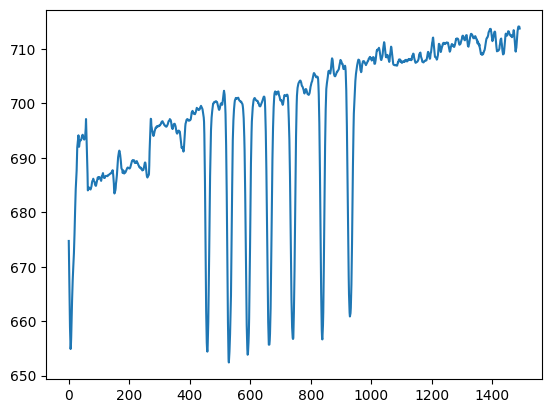

In [518]:
plt.plot(bouts_edited_dict[fly_db.fly_data[0].name]['distance.origin-prob'][fly_db.fly_data[0].trial_id])

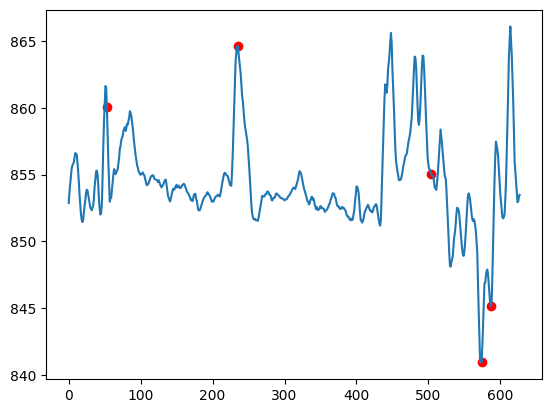

In [554]:
fdata = 21
plt.plot(bouts_edited_dict[fly_db.fly_data[fdata].name]['distance.origin-prob'][fly_db.fly_data[fdata].trial_id])

plt.scatter(fly_db.fly_data[fdata].peak_index, fly_db.fly_data[fdata].peak_values, color='red', label = 'Anomaly')

In [550]:
bouts_edited_dict[fly_db.fly_data[fdata].name]['Annotation'][fly_db.fly_data[fdata].trial_id]

True

In [540]:
len(fly_db.fly_data)

1951